# [Open in Google Colab](https://colab.research.google.com/github/Jechen00/yolov3-pytorch/blob/main/notebooks/custom_dataset_demo.ipynb)

# 0) Imports

In [1]:
import torch
from torchvision.tv_tensors import BoundingBoxes

import sys, os, glob
import random
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import patches
from typing import Optional, List, Union, Callable, Tuple, Literal, Any, Dict

# Importing torchmetrics (Not actually used here)
try:
    import torchmetrics
except:
    print('\033[1m[ALERT]\033[0m torchmetrics not found. Installing with pip...')
    !pip install torchmetrics

# Check if running in Google Colab
try:
    import google.colab
    print('\033[1m[ALERT]\033[0m Running in Google Colab.')
    IN_COLAB = True
    REPO_PATH = './yolov3-pytorch'

except ImportError:
    print('\033[1m[ALERT]\033[0m Running in yolov3-pytorch repository.')
    IN_COLAB = False
    REPO_PATH = '..'
    
# Clone repo if it doesn't exist
if IN_COLAB and (not os.path.exists(REPO_PATH)):
    print('\033[1m[ALERT]\033[0m Repository not found. Cloning yolov3-pytorch from GitHub...')
    !git clone https://github.com/Jechen00/yolov3-pytorch.git
        
# Import repo modules
sys.path.append(os.path.abspath(REPO_PATH))
from src.utils.constants import BOLD_START, BOLD_END
from src.utils import convert
from src.data_setup import dataset_utils, dataloader_utils
from src.data_setup.dataset_utils import DetectionDatasetBase
from src import postprocess

clear_output() # Clear the cluttered output after setup

---

# 1) Creating a Custom Dataset

The dataset we will be using in this demonstration is the aquarium dataset from https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots/data.
Make sure to download the dataset beforehand and move the `aquarium_pretrain` directory into the `yolov3-pytorch/data` directory. If you are running this notebook in Google Colab, you can refer to [this discussion](https://www.kaggle.com/discussions/general/74235) about downloading Kaggle datasets.

This dataset contains images of various sea animals: `'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'`. This dataset is split as follows: training (448 images), validation (127 images), and testing (63 images).

In [2]:
# Required dataset arguments for instantiation of DetectionDatasetBase: root, strides, scale_anchors

# Path to the root directory storing the training, validation, and testing splits
ROOT = os.path.join(REPO_PATH, 'data/aquarium_pretrain')

# Using the standard strides for a YOLOv3 model
STRIDES = [32, 16, 8]

# Using anchors derived from MS COCO 2014
# Should ideally be replaced by anchors from the custom dataset
    # Can use DetectionDatasetBase.regenerate_scale_anchors
scale_anchors = [
    torch.tensor([(116, 90), (156, 198), (373, 326)]),
    torch.tensor([(30, 61),  (62, 45),  (59, 119)]),
    torch.tensor([(10, 13),  (16, 30),  (33, 23)])
]

--- 

## 1.1) Create a `.names` File

The `.names` file is a plain text file with all the class names of the custom dataset.  Each line should contain exactly one class name, and the order must match the index assigned to that class in the dataset.

In [3]:
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
label_path = os.path.join(ROOT, 'aquarium.names') # Path to create the .names file in

with open(label_path, 'w') as f:
    for label in class_names:
        f.write(f'{label}\n')

To test if the `.names` file was created successfully, we can load in the class names and their corresponding colors with `dataset_utils.load_classes`.

In [4]:
class_names, class_clrs, class_to_idx = dataset_utils.load_classes(
    label_path = label_path,
    return_idx_map = True, # Returns a dictionary mapping class names to class indices
    clr_shuffle_seed = 0
)

# Colors are normalized RGB tuples
for label, clr in zip(class_names, class_clrs):
    idx = class_to_idx[label]
    print(f'{idx:<2} | {label:<10}  | {clr}')

0  | fish        | (0.33999999999999997, 0.6059428571428571, 0.86)
1  | jellyfish   | (0.4573714285714283, 0.86, 0.33999999999999997)
2  | penguin     | (0.86, 0.8169142857142857, 0.33999999999999997)
3  | puffin      | (0.86, 0.3712, 0.33999999999999997)
4  | shark       | (0.5197714285714281, 0.33999999999999997, 0.86)
5  | starfish    | (0.33999999999999997, 0.86, 0.6683428571428571)
6  | stingray    | (0.86, 0.33999999999999997, 0.7545142857142858)


---

## 1.2) Create a `CustomDataset` Class and Define its Required Dunder Methods

The custom dataset class needs to subclass `DetectionDatasetBase`.

The required dunder methods are:
  - `__init__(...)`: Initializes the dataset. 
      -  Must call `super().__init__(...)` with all [expect arguments](https://github.com/Jechen00/yolov3-pytorch/blob/main/src/data_setup/dataset_utils.py#L177)
      -  Must include a `split` argument (typically a Literal['train', 'val', 'test']) to indicate training, validation, and/or testing splits.
      -  Must include a `max_imgs` argument (int) to optionally limit the number of images loaded.
  - `__len__(...)`: Returns the number of images in the dataset.

<br></br>
The file structure of the `aquarium_pretrain` directory should look something like this:
```
aquarium_pretrain/
├── aquarium.names
├── train/
│   ├── images/
│   └── labels/
├── valid/
│   ├── images/
│   └── labels/
├── test/
│   ├── images/
│   └── labels/
└── ...

```

The `train`, `valid`, and `test` directories store the respective training, validation, and testing splits, where `images` aptly contains the images and `labels` contains the annotation information (label indices and bounding box coordinates). `CustomDataset` will need to map the `split` argument to these directory names to correctly get the `images` and `labels` paths. The `root` argument of `CustomDataset` will need to assume that it points to the `aquarium_pretrain` directory.

<br></br>
A typical file in `images` and `labels` looks like this:
- image file: `IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.jpg`
- label file: `IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.txt`

Each image file and label file ends in `.jpg` and `.txt`, respectively. Additionally, the `IMG_2274` in the file name refers to the unique image number and can be used to match image and label files.

Since `__len__(...)` needs to return the number of images in the dataset, as part of the initalization, I will create 2 lists:
- `img_paths` (List[str]): List of paths to all image files in the dataset.
- `anno_paths` (List[str]): List of paths to all label/annotation files in the dataset.

This is done using `glob.glob(...)` to create the list and `sorted(...)` to order it such that the indices in `img_paths` and `anno_paths` will align in terms of image numbers.

Since the `img_paths` and `anno_paths` are aligned, the `max_imgs` argument can also be easily implemented by randomly sampling indices from `range(len(img_paths))`.

<br></br>
Lastly, note that to create a subclass of `DetectionDatasetBase` and instantiate it, we must define the methods `get_img(...)` and `get_anno_info(...)`. This is done in steps 3 and 4, so we will use placeholders for now.

In [5]:
class CustomDataset(DetectionDatasetBase):
    '''
    An example custom dataset class using the aquarium dataset from:
        https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots/data
    
    Classes: fish, jellyfish, penguin, puffin, shark, starfish, stingray
    
    Splits:
        - train (448 images)
        - val (127 images)
        - test (63 images)
        
    '''
    
    def __init__(self, 
                 root: str, 
                 scale_anchors: List[torch.Tensor],
                 strides: List[Union[int, Tuple[int, int]]],
                 default_input_size: Union[int, Tuple[int, int]] = (416, 416),
                 split: Literal['train', 'val', 'test'] = 'train', 
                 
                 ignore_threshold: float = 0.5,
                 single_augs: Optional[Callable] = None,
                 multi_augs: Union[Literal['mosaic', 'mixup'], List[Literal['mosaic', 'mixup']]] = 'mosaic',
                 post_multi_augs: Optional[Callable] = None,
                 multi_aug_prob: float = 0.0,
                 mixup_alpha: float = 0.5,
                 
                 min_box_scale: float = 0.01,
                 max_imgs: Optional[int] = None):
        
        # Check if the root directory exists.
        # If it does, it's assumed that it follows the appropriate file structure
        # If it doesn't, you could write code to download it, but this example will just throw an error
        if not os.path.isdir(root):
            raise FileNotFoundError(f'Directory does not exist: {root}')
        
        # Check that the dataset includes at least 1 image
        if (max_imgs is not None) and (not max_imgs > 0):
            raise ValueError('Must have `max_imgs > 0` or `max_imgs = None`')
        
        # Maps the split name to the correct directory name
        split_dir_map = {
            'train': 'train',
            'val': 'valid',
            'test': 'test'
        }
    
        self.split = split
        self.max_imgs = max_imgs
        
        display_name = f'Aquarium {split.capitalize()} Dataset'
        label_path = os.path.join(root, 'aquarium.names') # Path to the .names file creates in Step 1
        
        # Initialize DetectionDatasetBase
        super().__init__(
            root = root, 
            label_path = label_path, 
            display_name = display_name,
            scale_anchors = scale_anchors,
            strides = strides, 
            default_input_size = default_input_size,
            ignore_threshold = ignore_threshold,
            single_augs = single_augs, 
            multi_augs = multi_augs,
            post_multi_augs = post_multi_augs,
            multi_aug_prob = multi_aug_prob, 
            mixup_alpha = mixup_alpha,
            min_box_scale = min_box_scale
        )
        
        # Paths to all image and annotation files
        img_pattern = os.path.join(root, f'{split_dir_map[split]}/images/*.jpg')
        anno_pattern = os.path.join(root, f'{split_dir_map[split]}/labels/*.txt')
        self.img_paths = sorted(glob.glob(img_pattern))
        self.anno_paths = sorted(glob.glob(anno_pattern))
        
        if (max_imgs is not None) and (max_imgs < self.__len__()):
            samp_idxs = random.sample(range(self.__len__()), max_imgs)
        
            self.img_paths = [self.img_paths[i] for i in samp_idxs]
            self.anno_paths = [self.anno_paths[i] for i in samp_idxs]
        
    def __len__(self):
        '''
        Returns the number of images in the dataset.
        '''
        return len(self.img_paths)
    
    def get_img(self, idx: int) -> Image.Image:
        '''
        Placeholder
        '''
        return
    
    def get_anno_info(self, idx: int) -> Dict[str, Any]:
        '''
        Placeholder
        '''
        return

In [6]:
custom_dataset = CustomDataset(root = ROOT, scale_anchors = scale_anchors, strides = STRIDES, max_imgs = None)

print(f'Number of Images: {len(custom_dataset)}')
print(f'First img_path: {custom_dataset.img_paths[0]}')
print(f'First anno_path: {custom_dataset.anno_paths[0]}')

Number of Images: 448
First img_path: ../data/aquarium_pretrain/train/images/IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.jpg
First anno_path: ../data/aquarium_pretrain/train/labels/IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.txt


---
## 1.3) Define a `get_imgs(...)` Method for `CustomDataset`

This method should take in an integer `idx` as input and return the corresponding dataset image as a PIL Image in RGB format.

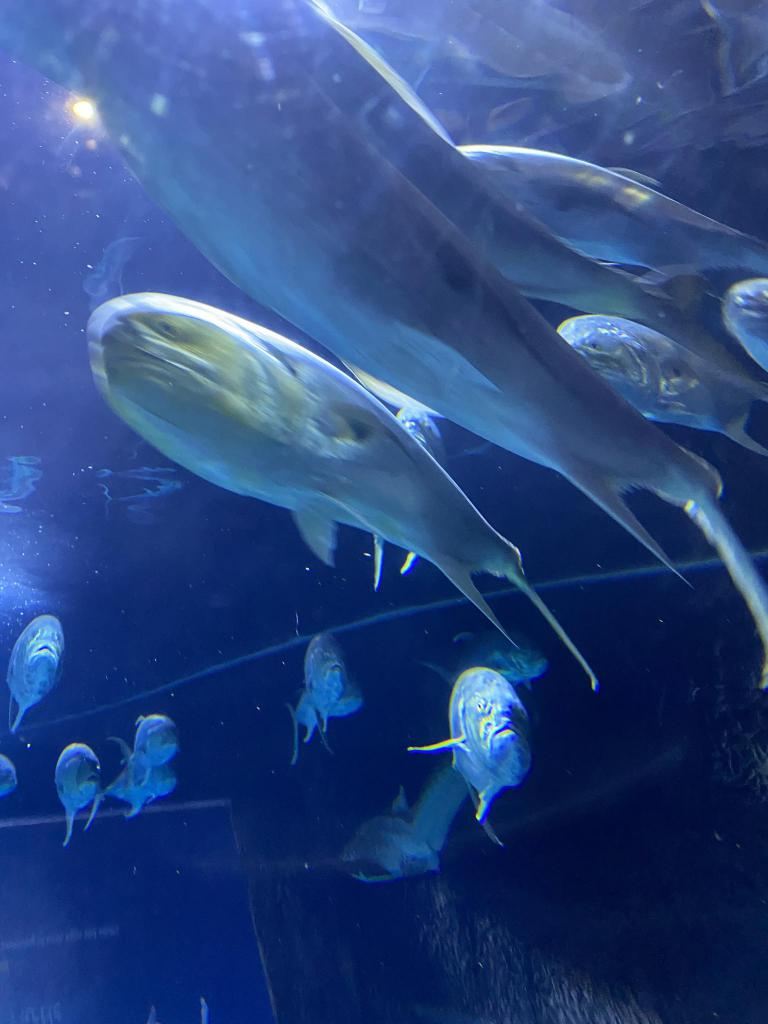

In [7]:
# Currently defined as a function, but should be a method of the class CustomDataset
def get_img(self, idx: int) -> Image.Image:
    '''
    Loads an original image from the dataset and converts it to RGB format
    '''
    pil_img = Image.open(self.img_paths[idx])
    return pil_img.convert('RGB')

get_img(custom_dataset, idx = 100)

## 1.4) Define a `get_anno_info(...)` Method for `CustomDataset` 
This method should take in an integer `idx` as input and return an annotation information dictionary for the corresponding dataset image.
The return dictionary should have the following keys:
  - `labels (torch.Tensor)`: A tensor of class label indices of each object in the image.
      - Shape: (num_objects,)
  - `boxes (BoundingBoxes)`: A `torchvision.tv_tensors.BoundingBoxes` object for the bounding box coordinates of each object.
      - Format: 'XYXY'
      - Canvas size: (image height, image width)
      - Shape: (num_objects, 4)
      
<br></br>
An example of a file from `labels` looks like:
```
0 0.150390625 0.75927734375 0.30078125 0.1494140625
0 0.3658854166666667 0.51953125 0.5807291666666666 0.146484375
0 0.8776041666666666 0.0693359375 0.24348958333333334 0.1376953125
0 0.8359375 0.376953125 0.3268229166666667 0.12109375
0 0.8541666666666666 0.4990234375 0.2890625 0.1162109375
0 0.08072916666666667 0.634765625 0.16145833333333334 0.111328125
0 0.037109375 0.04833984375 0.07421875 0.0966796875
0 0.7565104166666666 0.9365234375 0.4856770833333333 0.125
```
Each line represents a single object in the image and the format of the line is:
```
label_idx, x_center, y_center, width, height
```
The bounding box coordinates are provided in the normalized CXCYWH format, where the center coordinates and width/height (W, H) are relative to the image size (i.e. canvas size of (1, 1)). The `get_anno_info(...)` method will need to convert the coordinates to XYXY format and denormalize them.

In [8]:
# Currently defined as a function, but should be a method of the class CustomDataset
def get_anno_info(self, idx: int):
    '''
    Loads the annotation information (labels and bounding boxes)
    for an original image, untransformed image in the dataset.
    '''
    labels, bboxes = [], []
    with open(self.anno_paths[idx], 'r') as f:
        # Loop over object information lines
        for obj_line in f:
            label_idx, x_center, y_center, width, height = map(float, obj_line.split())

            labels.append(int(label_idx))
            bboxes.append(torch.tensor([x_center, y_center, width, height]))
    
    if len(bboxes) > 0:
        labels = torch.tensor(labels, dtype = torch.long) # Shape: (num_objects,)
        bboxes = torch.stack(bboxes, dim = 0) # Shape: (num_objects, 4) w/ last dimension in CXCYWH format
        
    else:
        labels = torch.empty(0, dtype = torch.long)
        bboxes = torch.empty((0, 4), dtype = torch.float32)

    # Denormalize (Get coordinates in pixel units)
    img = Image.open(self.img_paths[idx]) # Should probably make a list of image widths/heights
    img_w, img_h = img.size

    bboxes[:, ::2] *= img_w
    bboxes[:, 1::2] *= img_h

    # Convert to XYXY format
    bboxes = convert.cxcywh_to_xyxy(bboxes)

    anno_info = {
        'labels': labels,
        'boxes': BoundingBoxes(
            data = bboxes,
            format = 'XYXY',
            canvas_size = (img_h, img_w)
        )
    }
    
    return anno_info

get_anno_info(custom_dataset, idx = 100)

{'labels': tensor([0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'boxes': BoundingBoxes([[115.0000, 101.0000, 767.0000, 693.0000],
                [ 87.5000, 291.5000, 596.5000, 690.5000],
                [405.5000, 665.5000, 528.5000, 844.5000],
                [556.5000, 311.0000, 767.5000, 459.0000],
                [  5.5000, 614.5000,  62.5000, 731.5000],
                [340.5000, 786.5000, 439.5000, 885.5000],
                [ 57.0000, 743.0000,  99.0000, 841.0000],
                [304.5000, 629.0000, 343.5000, 725.0000],
                [725.0000, 279.0000, 767.0000, 371.0000],
                [286.5000, 679.5000, 359.5000, 760.5000],
                [105.0000, 761.0000, 175.0000, 823.0000],
                [112.0000, 714.5000, 178.0000, 775.5000],
                [448.5000, 631.5000, 545.5000, 680.5000],
                [  0.0000, 755.0000,  19.0000, 801.0000],
                [450.5000,  83.5000, 767.5000, 308.5000]], format=BoundingBoxFormat.XYXY, canvas_size=(1024, 768)

---
## 1.5) Putting it All Together

With the `get_img(...)` and `get_anno_info(...)` methods defined, we can create the full `CustomDataset` class. Note that in the `__init__(...)` method, I also added an attribute called `img_sizes`, which is a list of image sizes aligned with `img_paths`. This is because the annotation information is normalized, and we need to denormalize them in `get_anno_info(...)`.

In [9]:
class CustomDataset(DetectionDatasetBase):
    '''
    An example custom dataset class using the aquarium dataset from:
        https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots/data
    
    Classes: fish, jellyfish, penguin, puffin, shark, starfish, stingray
    
    Splits:
        - train (448 images)
        - val (127 images)
        - test (63 images)
        
    '''
    def __init__(self, 
                 root: str, 
                 scale_anchors: List[torch.Tensor],
                 strides: List[Union[int, Tuple[int, int]]],
                 default_input_size: Union[int, Tuple[int, int]] = (416, 416),
                 split: Literal['train', 'val', 'test'] = 'train', 
                 
                 ignore_threshold: float = 0.5,
                 single_augs: Optional[Callable] = None,
                 multi_augs: Union[Literal['mosaic', 'mixup'], List[Literal['mosaic', 'mixup']]] = 'mosaic',
                 post_multi_augs: Optional[Callable] = None,
                 multi_aug_prob: float = 0.0,
                 mixup_alpha: float = 0.5,
                 
                 min_box_scale: float = 0.01,
                 max_imgs: Optional[int] = None):
        
        # Check if the root directory exists.
        # If it does, it's assumed that it follows the appropriate file structure
        # If it doesn't, you could write code to download it, but this example will just throw an error
        if not os.path.isdir(root):
            raise FileNotFoundError(f'Directory does not exist: {root}')
        
        # Check that the dataset includes at least 1 image
        if max_imgs is not None:
            assert max_imgs > 0, 'Must have `max_imgs` > 0'
           
        # Maps the split name to the correct directory
        split_dir_map = {
            'train': 'train',
            'val': 'valid',
            'test': 'test'
        }
        
        self.split = split
        self.max_imgs = max_imgs
        
        display_name = f'Aquarium {split.capitalize()} Dataset'
        label_path = os.path.join(root, 'aquarium.names') # Path to the .names file creates in Step 1
        
        # Initialize DetectionDatasetBase
        super().__init__(
            root = root, 
            label_path = label_path, 
            display_name = display_name,
            scale_anchors = scale_anchors,
            strides = strides, 
            default_input_size = default_input_size,
            ignore_threshold = ignore_threshold,
            single_augs = single_augs, 
            multi_augs = multi_augs,
            post_multi_augs = post_multi_augs,
            multi_aug_prob = multi_aug_prob, 
            mixup_alpha = mixup_alpha,
            min_box_scale = min_box_scale
        )
        
        # Paths to all image and annotation files
        self.img_paths = sorted(glob.glob(os.path.join(root, f'{split_dir_map[split]}/images/*.jpg')))
        self.anno_paths = sorted(glob.glob(os.path.join(root, f'{split_dir_map[split]}/labels/*.txt')))
        
        if max_imgs is not None:
            max_imgs = min(max_imgs, self.__len__())
            samp_idxs = random.sample(range(self.__len__()), max_imgs)
        
            self.img_paths = [self.img_paths[i] for i in samp_idxs]
            self.anno_paths = [self.anno_paths[i] for i in samp_idxs]
            
        # Get image sizes (width, height) for denormalizing in get_anno_info
        self.img_sizes = [
            Image.open(path).size
            for path in self.img_paths
        ]
        
    def __len__(self) -> int:
        '''
        Returns the number of images in the dataset.
        '''
        return len(self.img_paths)
    
    def get_img(self, idx: int) -> Image.Image:
        '''
        Loads an original image from the dataset and converts it to RGB format
        '''
        pil_img = Image.open(self.img_paths[idx])
        return pil_img.convert('RGB')
    
    def get_anno_info(self, idx: int) -> Dict[str, Any]:
        '''
        Loads the annotation information (labels and bounding boxes)
        for an original image, untransformed image in the dataset.
        '''
        labels, bboxes = [], []
        with open(self.anno_paths[idx], 'r') as f:
            # Loop over object information lines
            for obj_line in f:
                label_idx, x_center, y_center, width, height = map(float, obj_line.split())

                labels.append(int(label_idx))
                bboxes.append(torch.tensor([x_center, y_center, width, height]))
        
        if len(bboxes) > 0:
            labels = torch.tensor(labels, dtype = torch.long) # Shape: (num_objects,)
            bboxes = torch.stack(bboxes, dim = 0) # Shape: (num_objects, 4) w/ last dimension in CXCYWH format

        else:
            labels = torch.empty(0, dtype = torch.long)
            bboxes = torch.empty((0, 4), dtype = torch.float32)

        # Denormalize (Get coordinates in pixel units)
        img_w, img_h = self.img_sizes[idx]

        bboxes[:, ::2] *= img_w
        bboxes[:, 1::2] *= img_h

        # Convert to XYXY format
        bboxes = convert.cxcywh_to_xyxy(bboxes)

        anno_info = {
            'labels': labels,
            'boxes': BoundingBoxes(
                data = bboxes,
                format = 'XYXY',
                canvas_size = (img_h, img_w)
            )
        }

        return anno_info

---
## 1.6) (Optional) Regenerating Anchors

With the `CustomDataset` class finished, we can optionally regenerate anchors for the dataset using `CustomDataset.regenerate_scale_anchors(...)`. This computes `k` anchors for the dataset with k-means clustering.

**Note:** To instantiate `CustomDataset`, an inital set of scale anchors is still needed for the `scale_anchors` argument.

In [10]:
custom_dataset = CustomDataset(root = ROOT, scale_anchors = scale_anchors, strides = STRIDES, max_imgs = None)

print('Old scale anchors:')
for anchors in custom_dataset.scale_anchors:
    print(anchors)
print()

custom_dataset.regenerate_scale_anchors(
    anchors_per_scale = (3, 3, 3), # 3 scales with 3 anchors each
    max_iters = 10000,
    update_method = 'median', # Use cluster median to update
    input_size = (416, 416) # Normalize wrt (416, 416)
)

print('New scale anchors:')
for anchors in custom_dataset.scale_anchors:
    print(anchors)
    
scale_anchors = custom_dataset.scale_anchors # Update scale anchors to the regenerated ones

Old scale anchors:
tensor([[116,  90],
        [156, 198],
        [373, 326]])
tensor([[ 30,  61],
        [ 62,  45],
        [ 59, 119]])
tensor([[10, 13],
        [16, 30],
        [33, 23]])

New scale anchors:
tensor([[186., 119.],
        [102.,  51.],
        [ 47.,  72.]])
tensor([[68., 31.],
        [28., 36.],
        [47., 20.]])
tensor([[28., 14.],
        [14., 22.],
        [ 8., 10.]])


# 2) Creating Dataloaders

Dataloaders can be constructed with `dataloader_utils.get_dataloaders(...)`. The arguments for this function can be found [here](https://github.com/Jechen00/yolov3-pytorch/blob/main/src/data_setup/dataloader_utils.py#L54).

Since we did not add `CustomDataset` to the `DATASETS` dictionary in [data_setup/dataloader_utils.py](https://github.com/Jechen00/yolov3-pytorch/blob/main/src/data_setup/dataloader_utils.py) for this demonstration, we will use the `dataset_class` argument of `dataloader_utils.get_dataloaders(...)`.

In [11]:
loaders = dataloader_utils.get_dataloaders(
    root = ROOT,
    batch_size = 10,
    scale_anchors = scale_anchors,
    strides = STRIDES,
    default_input_size = (416, 416),
    
    dataset_class = CustomDataset, # Set which dataset to create dataloaders for
    splits = ['train', 'val', 'test'],
    max_imgs = None,
    
    ignore_threshold = 0.5,
    multi_augs = ['mosaic', 'mixup'],
    multi_aug_prob = 0.5,
    mixup_alpha = 3.0,
    multiscale_interval = 2, # Change input size every 2 batches
    multiscale_sizes = torch.arange(320, 608 + 32, 32).tolist(),
    min_box_scale = 0.01,

    num_workers = 0,
    device = 'cpu',
    return_builders = False, # Returns the already built DataLoaders
)

for loader in loaders.values():
    print(loader.dataset)

Dataset: Aquarium Train Dataset
    Root location: ../data/aquarium_pretrain
    Number of samples: 448
    Number of classes: 7
    Strides: [(32, 32), (16, 16), (8, 8)]
    Default Input Size: (416, 416)
    Default Image shape: (3, 416, 416)
    Default Target shapes: [(3, 13, 13, 12), (3, 26, 26, 12), (3, 52, 52, 12)]

Dataset: Aquarium Val Dataset
    Root location: ../data/aquarium_pretrain
    Number of samples: 127
    Number of classes: 7
    Strides: [(32, 32), (16, 16), (8, 8)]
    Default Input Size: (416, 416)
    Default Image shape: (3, 416, 416)
    Default Target shapes: [(3, 13, 13, 12), (3, 26, 26, 12), (3, 52, 52, 12)]

Dataset: Aquarium Test Dataset
    Root location: ../data/aquarium_pretrain
    Number of samples: 63
    Number of classes: 7
    Strides: [(32, 32), (16, 16), (8, 8)]
    Default Input Size: (416, 416)
    Default Image shape: (3, 416, 416)
    Default Target shapes: [(3, 13, 13, 12), (3, 26, 26, 12), (3, 52, 52, 12)]



## 2.1) Testing Multiscale Training

Multiscale training changes the size of the input image every `x` batches.

In [12]:
train_loader = loaders['train']
multiscale_interval = train_loader.batch_sampler.multiscale_interval

print(f'{BOLD_START}Input size should change every '
      f'{multiscale_interval} batches{BOLD_END}')

num_printed_batches = 10
for i, (imgs, scale_targs) in enumerate(train_loader):
    print(f'Image Shape: {imgs.shape}')
    
    if (i + 1) % multiscale_interval == 0:
        print()
        
    if i > num_printed_batches:
        break

Input size should change every 2 batches
Image Shape: torch.Size([10, 3, 416, 416])
Image Shape: torch.Size([10, 3, 416, 416])

Image Shape: torch.Size([10, 3, 576, 576])
Image Shape: torch.Size([10, 3, 576, 576])

Image Shape: torch.Size([10, 3, 512, 512])
Image Shape: torch.Size([10, 3, 512, 512])

Image Shape: torch.Size([10, 3, 448, 448])
Image Shape: torch.Size([10, 3, 448, 448])

Image Shape: torch.Size([10, 3, 384, 384])
Image Shape: torch.Size([10, 3, 384, 384])

Image Shape: torch.Size([10, 3, 448, 448])
Image Shape: torch.Size([10, 3, 448, 448])



---
# 3) Plotting Dataset Images

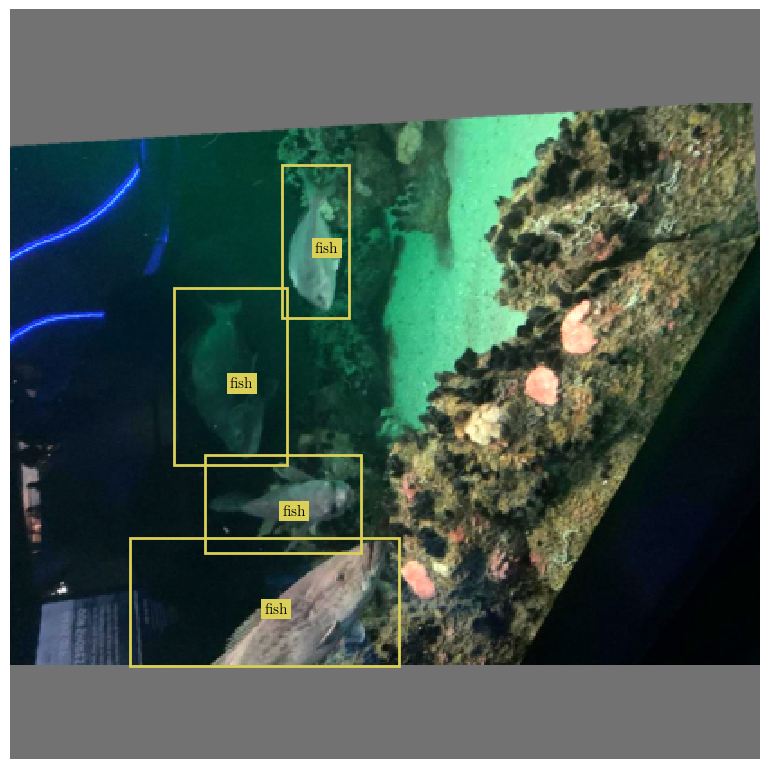

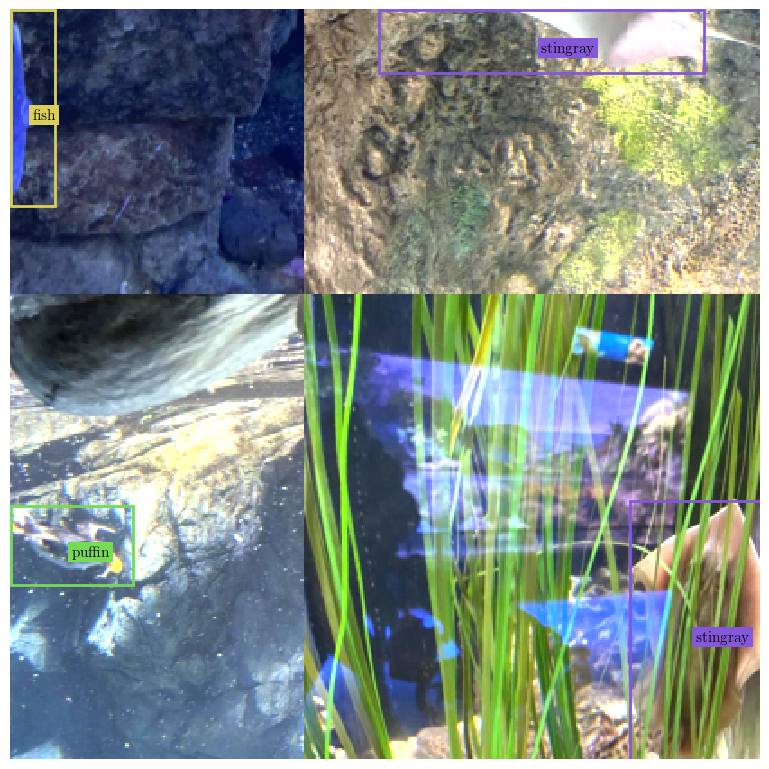

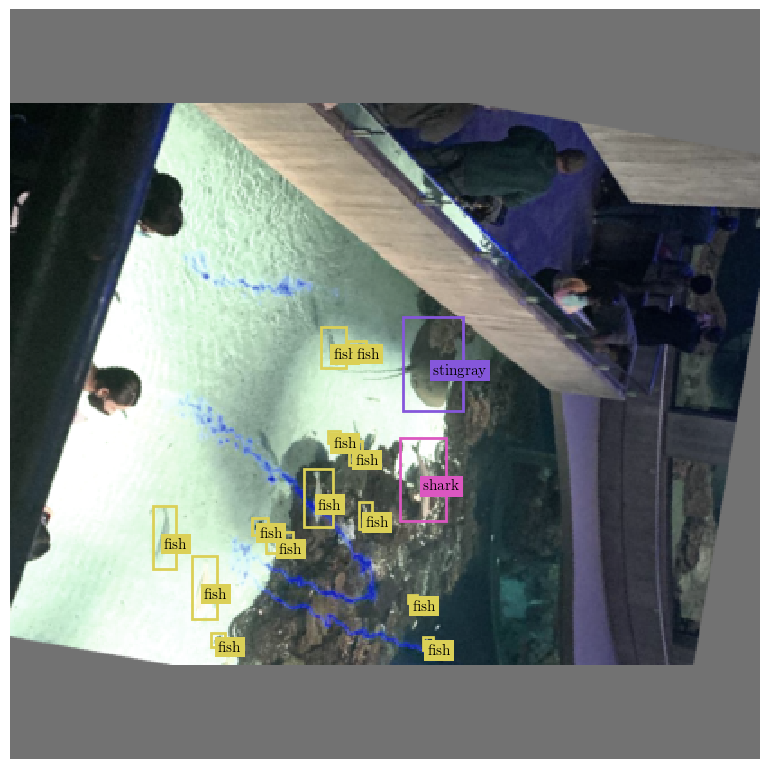

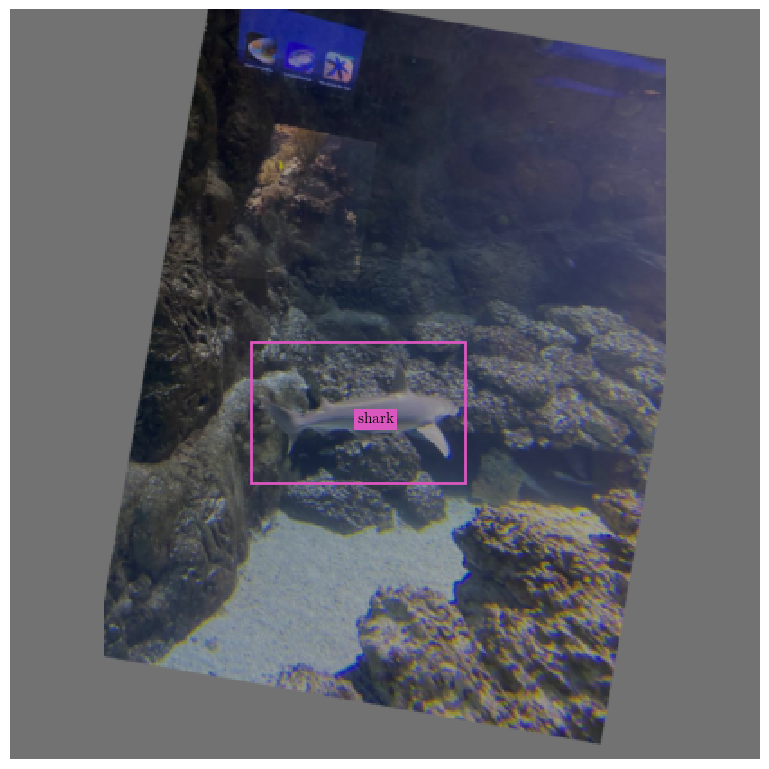

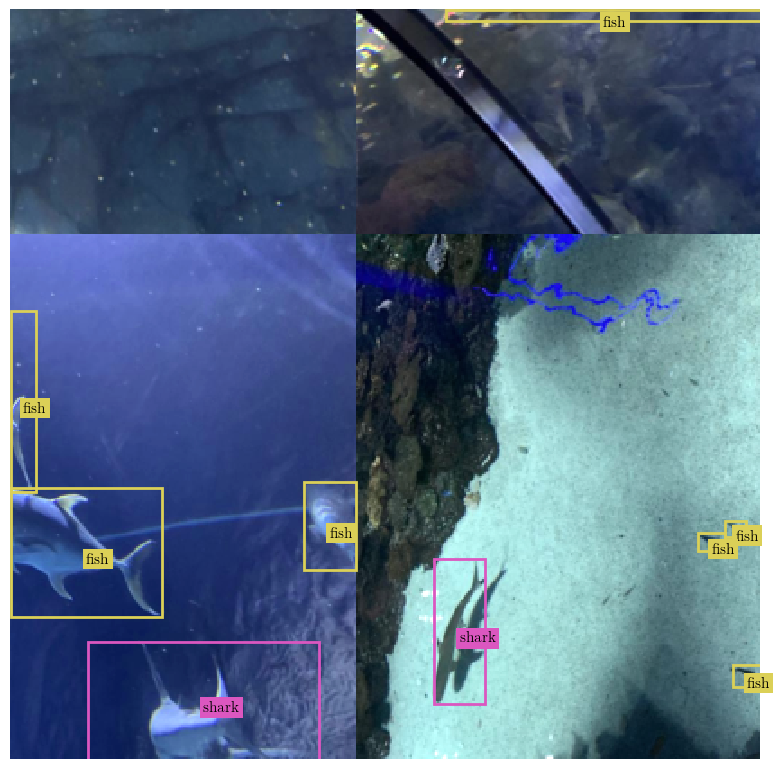

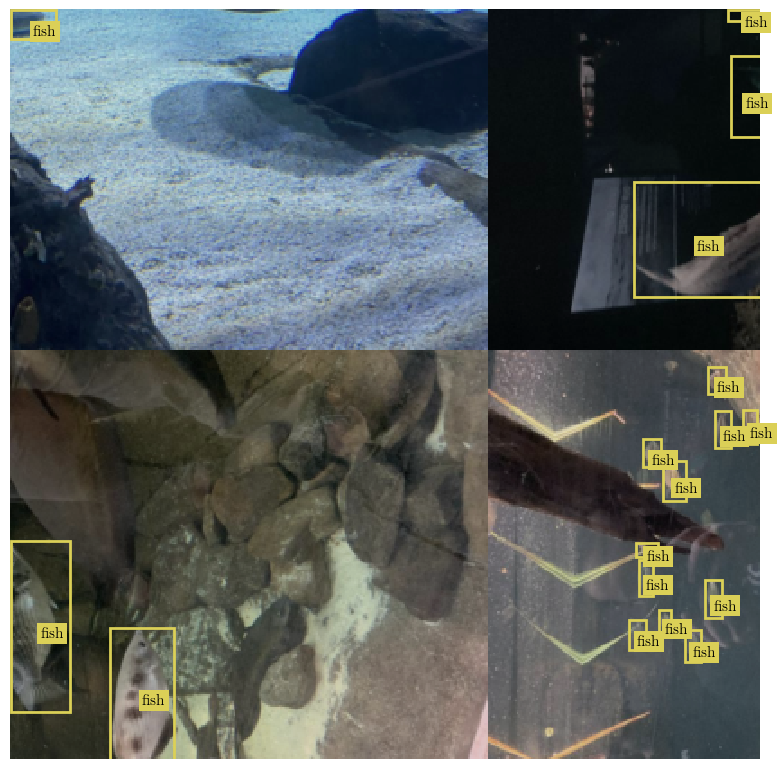

In [13]:
dataset = loaders['train'].dataset

num_samps = 10
samp_idxs = random.sample(range(len(dataset)), num_samps)

for img_idx in samp_idxs:
    img, scale_targs = dataset[img_idx]
    
    scale_targs = [targs.unsqueeze(0) for targs in scale_targs]
    targs_res = postprocess.decode_yolov3_targets(scale_targs, scale_anchors, STRIDES)[0]

    fig = plt.figure(figsize = (10, 10))
    plt.imshow(img.permute(1, 2, 0)) # Permute to (H, W, C)

    for bbox, label in zip(targs_res['boxes'], targs_res['labels']):
        xmin, ymin, xmax, ymax = bbox.cpu()

        bbox_w = xmax - xmin
        bbox_h = ymax - ymin

        txt_x = xmin + bbox_w / 2
        txt_y = ymin + bbox_h / 2

        clr = dataset.class_clrs[label.item()]

        rec = patches.Rectangle((xmin, ymin), bbox_w, bbox_h, edgecolor = clr,
                                linewidth = 2, facecolor = 'none')

        plt.gca().add_patch(rec)

        txt = f'{dataset.class_names[label.item()]}'
        plt.text(txt_x, txt_y, txt,
                 fontsize = 11, color = 'k',
                 ha = 'left', va = 'top',
                 bbox = dict(alpha = 1, pad = 2.5, 
                             edgecolor = 'none', facecolor = clr))
        
    plt.axis(False)
    plt.show()